# <center>Artificial Neural Networks and Cognitive Models</center>

# <center>TASK - 1</center>

## Digit Predictor

In [1]:
import torch
import numpy as np
import csv
import time
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from matplotlib import pyplot as plt
import torchvision
from torchvision import datasets, transforms
from torch import optim
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from matplotlib import pyplot as plt

import os 
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# send model to train on gpu if available else it uses your cpu
device = ("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])
# mean = 0.1307 # standard deviation = 0.3081 # for mnist data

# Download and load the training data
train_set = datasets.MNIST('DATA_MNIST/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

# Download and load the test data
test_set = datasets.MNIST('DATA_MNIST/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True)

In [3]:
training_data = enumerate(trainloader)
batch_idx, (images, labels) = next(training_data)
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


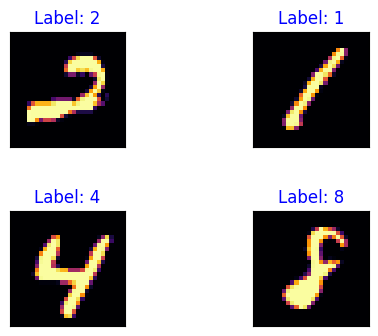

In [4]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(6, 4))

for i in range(4):
    # Create subplot
    ax = plt.subplot(2, 2, i + 1)

    # Display the image
    ax.imshow(images[i][0], cmap='inferno')

    # Set the title with improved formatting
    ax.set_title(f"Label: {labels[i]}", fontsize=12, color='blue')

    # Remove ticks from x and y axes
    ax.set_xticks([])
    ax.set_yticks([])

# Adjust layout for better spacing
plt.tight_layout(pad=3.0)

# Show the figure
plt.show()


### APPROACH - 1 : MLP

In [5]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        # Input layer
        self.input_layer = nn.Linear(in_features=28*28, out_features=128)  # Assuming input images are 28x28 pixels
        # Hidden layers
        self.hidden_layer1 = nn.Linear(in_features=128, out_features=256)
        self.hidden_layer2 = nn.Linear(in_features=256, out_features=128)
        # Output layer
        self.output_layer = nn.Linear(in_features=128, out_features=10)  # Assuming 10 classes for classification

    def forward(self, x):
        # Flatten the input
        x = x.view(x.size(0), -1)
        # Activation functions for hidden layers
        x = F.relu(self.input_layer(x))
        x = F.relu(self.hidden_layer1(x))
        x = F.relu(self.hidden_layer2(x))
        x = self.output_layer(x)
        return x

# Instantiate the model
mlp_model = MLP()
mlp_model.to(device)
print(mlp_model)


MLP(
  (input_layer): Linear(in_features=784, out_features=128, bias=True)
  (hidden_layer1): Linear(in_features=128, out_features=256, bias=True)
  (hidden_layer2): Linear(in_features=256, out_features=128, bias=True)
  (output_layer): Linear(in_features=128, out_features=10, bias=True)
)


In [6]:
import torch.optim as optim

#optimizer and loss function for MLP
optimizer = optim.SGD(mlp_model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
epochs = 15

train_losses = []
test_losses = []

# Training loop
for epoch in range(epochs):
    mlp_model.train()
    train_loss = 0

    for idx, (images, labels) in enumerate(trainloader): 

        # Send these to Gpu
        images = images.to(device)
        labels = labels.to(device)

        # Training pass
        optimizer.zero_grad()

        # Forward pass
        output = mlp_model(images)
        loss = criterion(output, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        
    else:
        # prep model for evaluation
        mlp_model.eval() 
        test_loss = 0
        accuracy = 0
        
        with torch.no_grad():
            for images, labels in testloader:
                
                images = images.to(device)
                labels = labels.to(device)
                
                log_probabilities = mlp_model(images)
                test_loss += criterion(log_probabilities, labels)

                probabilities = torch.exp(log_probabilities)
                top_prob, top_class = probabilities.topk(1, dim=1)
                predictions = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(predictions.type(torch.FloatTensor))
        
        train_losses.append(train_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        
        print("Epoch: {}/{}  ".format(epoch+1, epochs),
              "Training loss: {:.4f}  ".format(train_loss/len(trainloader)),
              "Testing loss: {:.4f}  ".format(test_loss/len(testloader)),
              "Test accuracy: {:.4f}  ".format(accuracy/len(testloader)))


Epoch: 1/15   Training loss: 1.1348   Testing loss: 0.3918   Test accuracy: 0.8880  
Epoch: 2/15   Training loss: 0.3405   Testing loss: 0.2781   Test accuracy: 0.9184  
Epoch: 3/15   Training loss: 0.2652   Testing loss: 0.2356   Test accuracy: 0.9303  
Epoch: 4/15   Training loss: 0.2208   Testing loss: 0.2001   Test accuracy: 0.9385  
Epoch: 5/15   Training loss: 0.1887   Testing loss: 0.1704   Test accuracy: 0.9499  
Epoch: 6/15   Training loss: 0.1632   Testing loss: 0.1582   Test accuracy: 0.9554  
Epoch: 7/15   Training loss: 0.1436   Testing loss: 0.1375   Test accuracy: 0.9596  
Epoch: 8/15   Training loss: 0.1278   Testing loss: 0.1275   Test accuracy: 0.9614  
Epoch: 9/15   Training loss: 0.1141   Testing loss: 0.1219   Test accuracy: 0.9637  
Epoch: 10/15   Training loss: 0.1026   Testing loss: 0.1110   Test accuracy: 0.9672  
Epoch: 11/15   Training loss: 0.0928   Testing loss: 0.1038   Test accuracy: 0.9684  
Epoch: 12/15   Training loss: 0.0846   Testing loss: 0.0990   T

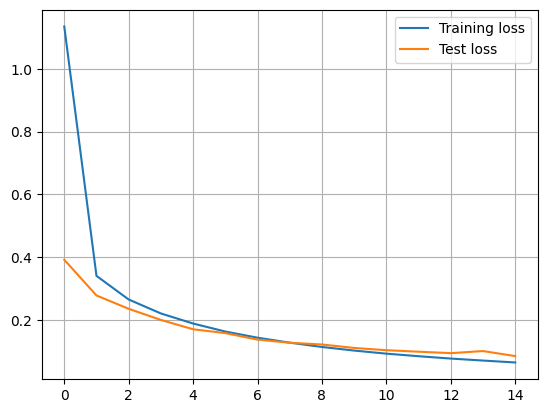

In [7]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Test loss')
plt.legend()
plt.grid()

### APPROACH-2: CNN

In [8]:
class Network(nn.Module):

    def __init__(self):
        super(Network, self).__init__()
        # Convolutional Neural Network Layer 
        self.convolutaional_neural_network_layers = nn.Sequential(
                nn.Conv2d(in_channels=1, out_channels=12, kernel_size=3, padding=1, stride=1), # (N, 1, 28, 28) 
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2), 
                nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, padding=1, stride=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2),
                nn.Conv2d(in_channels=24, out_channels=48, kernel_size=3, padding=1, stride=1),  
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2)
        )

        # Linear layer
        self.linear_layers = nn.Sequential(
                nn.Linear(in_features=48*3*3, out_features=64),  # Adjusting the input size based on the output of the last convolutional layer         
                nn.ReLU(),
                nn.Dropout(p=0.25),  # Dropout with probability of 0.25 to avoid overfitting
                nn.Linear(in_features=64, out_features=10 )# The output is 10 which should match the size of our class
        )

    # Defining the forward pass 
    def forward(self, x):
        x = self.convolutaional_neural_network_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        x = F.log_softmax(x, dim=1)
        return x

# Instantiate the model
model = Network()
model.to(device)
print(model)

Network(
  (convolutaional_neural_network_layers): Sequential(
    (0): Conv2d(1, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(24, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=432, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=64, out_features=10, bias=True)
  )
)


In [9]:
optimizer = optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
epochs = 15

train_losses = []
test_losses = []

for epoch in range(epochs):
    model.train()
    train_loss = 0

    for idx, (images, labels) in enumerate(trainloader): 

        # Send these to Gpu
        images = images.to(device)
        labels = labels.to(device)

        # Training pass
        optimizer.zero_grad()

        # Forward pass
        output = model(images)
        loss = criterion(output, labels)

        #Backward pass
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        
    else:
        # prep model for evaluation
        model.eval() 
        test_loss = 0
        accuracy = 0
        
        with torch.no_grad():
            for images, labels in testloader:
                
                images = images.to(device)
                labels = labels.to(device)
                
                log_probabilities = model(images)
                test_loss += criterion(log_probabilities, labels)

                probabilities = torch.exp(log_probabilities)
                top_prob, top_class = probabilities.topk(1, dim=1)
                predictions = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(predictions.type(torch.FloatTensor))
        
        train_losses.append(train_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        
        print("Epoch: {}/{}  ".format(epoch+1, epochs),
              "Training loss: {:.4f}  ".format(train_loss/len(trainloader)),
              "Testing loss: {:.4f}  ".format(test_loss/len(testloader)),
              "Test accuracy: {:.4f}  ".format(accuracy/len(testloader)))

Epoch: 1/15   Training loss: 1.2984   Testing loss: 0.3106   Test accuracy: 0.9110  
Epoch: 2/15   Training loss: 0.2943   Testing loss: 0.1594   Test accuracy: 0.9528  
Epoch: 3/15   Training loss: 0.1856   Testing loss: 0.1141   Test accuracy: 0.9654  
Epoch: 4/15   Training loss: 0.1453   Testing loss: 0.0962   Test accuracy: 0.9690  
Epoch: 5/15   Training loss: 0.1223   Testing loss: 0.0706   Test accuracy: 0.9772  
Epoch: 6/15   Training loss: 0.1074   Testing loss: 0.0756   Test accuracy: 0.9736  
Epoch: 7/15   Training loss: 0.0959   Testing loss: 0.0619   Test accuracy: 0.9793  
Epoch: 8/15   Training loss: 0.0871   Testing loss: 0.0520   Test accuracy: 0.9833  
Epoch: 9/15   Training loss: 0.0812   Testing loss: 0.0509   Test accuracy: 0.9837  
Epoch: 10/15   Training loss: 0.0751   Testing loss: 0.0492   Test accuracy: 0.9843  
Epoch: 11/15   Training loss: 0.0705   Testing loss: 0.0475   Test accuracy: 0.9847  
Epoch: 12/15   Training loss: 0.0656   Testing loss: 0.0447   T

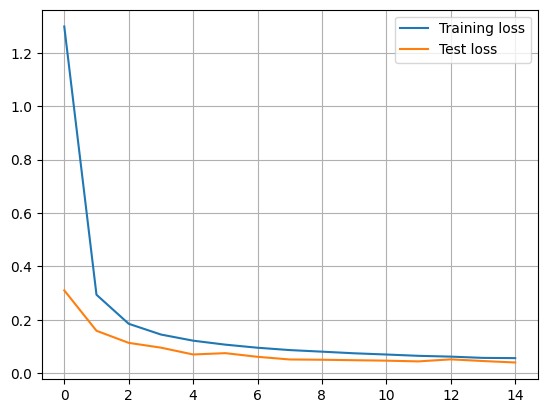

In [10]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Test loss')
plt.legend()
plt.grid()

In [11]:
# Save the model
model_path = 'C:\Semester 2\ANN\Portfolio1\my_model1.pt'
torch.save(model, model_path)

# Apply for our case

As we got good accuracy for CNN, I am using CNN trained model to predict our test set.

In [12]:
test = np.load("C:\Semester 2\ANN\Portfolio1\Test_set\imgs.npy")
def get_digits(sudoku_image, row, column, digit_size=28):
    # Determine the height and width of each cell in the grid
    grid_height, grid_width = sudoku_image.shape[:2]
    cell_height = grid_height // 9
    cell_width = grid_width // 9

    # Calculate the top-left corner of the specified cell
    start_y = row * cell_height
    start_x = column * cell_width

    # Crop the image to get the digit, ensuring it fits into the digit_size
    digit_image = Image.fromarray(sudoku_image[start_y:start_y+cell_height, start_x:start_x+cell_width])
    digit_image = digit_image.resize((digit_size, digit_size), Image.ANTIALIAS)

    # Convert Image to a NumPy array
    digit_array = np.array(digit_image)

    return digit_image, digit_array

In [13]:
trained_model = torch.load(r"C:\Semester 2\ANN\Portfolio1\my_model1.pt",map_location=torch.device('cpu'))

In [14]:
# make predictions for test image
test_preds_ids = []
test_preds_values = []
for image_idx in range(test.shape[0]):
    for row in range(0,9):
        for col in range(0,9):
                test_image , _ = get_digits(test[image_idx], row , col)
                #create numpy_array
                img = np.array(test_image)
                # convert it to tensor
                img = torch.tensor(img,  dtype=torch.float32)
                img = img.to(device)
                img = img.view(-1, 1, 28, 28)
                with torch.no_grad():
                    is_zero = torch.all(img == 0).item()
                    if is_zero:
                        pred = 0
                    else : 
                        logits = trained_model.forward(img)
                        probabilities = F.softmax(logits, dim=1).detach().cpu().numpy().squeeze()
                        pred = np.argmax(probabilities)
                id = str(image_idx)+'_' + str(row) + str(col)
                test_preds_ids.append(id)
                test_preds_values.append(pred)

C:\Users\korin\AppData\Local\Temp\ipykernel_17920\1296424760.py:14: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  digit_image = digit_image.resize((digit_size, digit_size), Image.ANTIALIAS)


In [15]:
import pandas as pd
results = pd.DataFrame({'id': test_preds_ids , 'values' : test_preds_values})
results

,id,values
0,0_00,2
1,0_01,0
2,0_02,7
3,0_03,0
4,0_04,1
...,...,...
809995,9999_84,3
809996,9999_85,5
809997,9999_86,2
809998,9999_87,0


In [16]:
results.to_csv('submission_kaggle_Task_1.csv', index = False)

#### Conclusion:
        I tried both MLP and CNN for our test set. When I submitted MLP results, I got 96% Accuracy in kaggle. For CNN, I got 99.997% which is best score of all my submission

**Name: THARUN KUMAR KORINE PALLI**

**Matriculation Number: 5123708**

**Email: tharunkumar.korinepalli@study.thws.de**


# <center>THE END</center>